<h1><center> MACHINE LEARNING - PROJECT </center></h1>
<center> "WHAT ARE THE PEOPLE MORE LIKELY TO SURVIVE TO THE BOOLEAN PANDEMIC?"</center>

Notebook structure:
* [1. Sample](#sample)
    * [1.1. Import Libraries](#import)
    * [1.2. Import Datasets](#import2)
* [2. Explore](#explore)
    * [2.1. Data Exploration](#dataexplore)
    * [2.2. Missing Values Analysis](#miss_values)
    * [2.3. Outliers Analysis](#outliers)
* [3. Modify](#modify)
    * [3.1. Transform and Create variables](#transf_create)
    * [3.2. Coherence Checking](#coherence)
    * [3.3. Correlation analysis](#corr)
    * [3.4. Feature Selection](#feature)
    * [3.5. Train Validation Partition](#train_val)
    * [3.6. Data Standardization](#datastand)
* [4. Model](#model)
* [5. Assess](#assess)

<hr>
<a class="anchor" id="sample">
    
# 1. Sample
    
</a>

<a class="anchor" id="import">

## 1.1. Import Libraries

</a>

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer 
from sklearn.linear_model import LassoCV, RidgeCV
import numpy as np

<a class="anchor" id="import2">

## 1.2. Import Datasets

</a>

In [40]:
df = pd.read_csv(r'Data/train.csv')
test_df = pd.read_csv(r'Data/test.csv')

<hr>
<a class="anchor" id="explore">
    
# 2. Explore
    
</a>

<a class="anchor" id="dataexplore">

## 2.1. Data Exploration

</a>

In [41]:
df.shape

(900, 11)

In [42]:
df.head(5)

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient_ID                         900 non-null    int64  
 1   Family_Case_ID                     900 non-null    int64  
 2   Severity                           900 non-null    int64  
 3   Name                               900 non-null    object 
 4   Birthday_year                      723 non-null    float64
 5   Parents or siblings infected       900 non-null    int64  
 6   Wife/Husband or children infected  900 non-null    int64  
 7   Medical_Expenses_Family            900 non-null    int64  
 8   Medical_Tent                       198 non-null    object 
 9   City                               898 non-null    object 
 10  Deceased                           900 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 77.5+ KB


In [44]:
df.describe()

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Deceased
count,900.000000,900.000000,900.000000,723.000000,900.000000,900.000000,900.000000,900.000000
mean,450.500000,14305.827778,2.313333,1990.266943,0.380000,0.521111,895.743333,0.614444
std,259.951919,25418.153900,0.834223,14.523335,0.803247,1.098385,1385.829926,0.486997
min,1.000000,345.000000,1.000000,1940.000000,0.000000,0.000000,0.000000,0.000000
25%,225.750000,8203.000000,2.000000,1982.000000,0.000000,0.000000,221.000000,0.000000
50%,450.500000,13593.500000,3.000000,1992.000000,0.000000,0.000000,405.000000,1.000000
75%,675.250000,18906.500000,3.000000,1999.500000,0.000000,1.000000,861.250000,1.000000
max,900.000000,742836.000000,3.000000,2019.000000,6.000000,8.000000,14345.000000,1.000000


In [45]:
df['Deceased'].value_counts(normalize=True)

1    0.614444
0    0.385556
Name: Deceased, dtype: float64

`NOTE:` Unbalanced learning, test over/under sampling.

<a class="anchor" id="miss_values">

## 2.2. Missing Values Analysis

</a>

In [46]:
print("# of missing values by variable:")
df.isnull().sum()

# of missing values by variable:


Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64

In [47]:
print("# of missing values by variable:")
test_df.isnull().sum()

# of missing values by variable:


Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                         82
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         311
City                                   0
dtype: int64

##### Medical Tent

We will drop the variable "Medical Tent", once it as 702 missing values from a total of 900 (78%)

In [48]:
df = df.drop(columns='Medical_Tent')
test_df = test_df.drop(columns='Medical_Tent')

##### City

 To fill the missing values in the variable "City", we decide to use the mode, since there are only to observations missing city

In [49]:
df.City.value_counts()

Santa Fe       649
Albuquerque    169
Taos            80
Name: City, dtype: int64

In [50]:
df['City'] = df['City'].fillna(df['City'].mode()[0])

In [51]:
df.City.value_counts()

Santa Fe       651
Albuquerque    169
Taos            80
Name: City, dtype: int64

##### Birthday Year

In what concerns the remaining missing values, all from the variable "Birthday Year", we decided to apply the K-Nearest-Neighbor algorithm to fill them. This decision was based in the fact that there are 177 missing values, which we consider too much for apllying a simple input (such as mean or median input), but not that many too remove a variable that we consider that might have some importance in our model. 
Later, with more knowledge of the dataset we might consider remove it.

In [52]:
# For training
knn_vars = df.drop(['Patient_ID', 'Name', 'City', 'Deceased'], axis = 1)
imputer = KNNImputer(n_neighbors=10)
X_filled_knn = imputer.fit_transform(knn_vars)
years = np.round(X_filled_knn[:,2])

for i in range(len(knn_vars)):
    if knn_vars.loc[i,'Birthday_year'] < 1900:
        print (years[i])
        
df['Birthday_year'] = years

# For Test
knn_vars_test = test_df.drop(['Patient_ID', 'Name', 'City'], axis = 1)
imputer = KNNImputer(n_neighbors=10)
Xtest_filled_knn = imputer.fit_transform(knn_vars_test)
years_df = np.round(Xtest_filled_knn[:,2])
test_df['Birthday_year'] = years_df

In [53]:
df['Birthday_year'].median()

1992.0

In [54]:
df['Birthday_year'].fillna(1992, inplace=True)

<a class="anchor" id="outliers">

## 2.3. Outliers Analysis

</a>

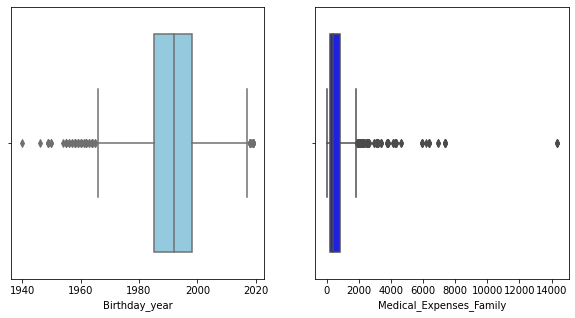

In [55]:
f, axes = plt.subplots(1,2, figsize=(10, 5), squeeze=False)    
sns.boxplot(df["Birthday_year"], color="skyblue", ax=axes[0, 0])
sns.boxplot(df["Medical_Expenses_Family"], color="blue", ax=axes[0, 1])

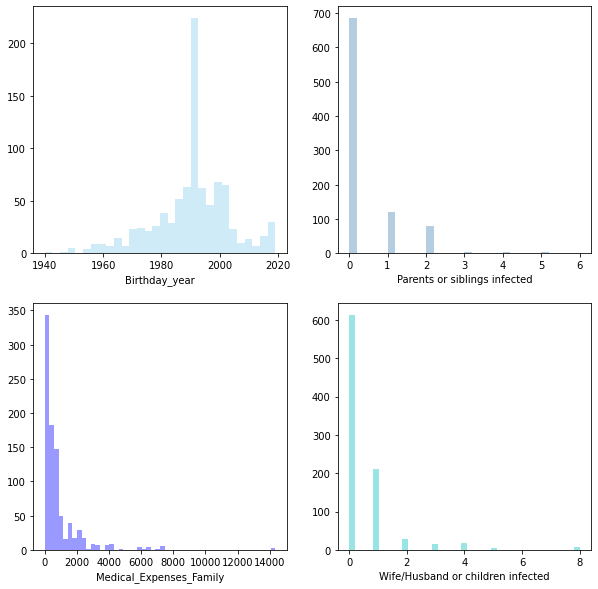

In [56]:
f, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.distplot(df["Birthday_year"], color="skyblue", ax=axes[0, 0], kde=False)
sns.distplot(df["Parents or siblings infected"], color="steelblue", ax=axes[0, 1], kde=False)
sns.distplot(df["Medical_Expenses_Family"], color="blue", ax=axes[1, 0], kde=False)
sns.distplot(df["Wife/Husband or children infected"], color="c", ax=axes[1, 1], kde=False)

In [57]:
df['Outlier'] = 0
df.loc[df['Medical_Expenses_Family']>13000, 'Outlier']=1
df['Outlier'].value_counts()

0    897
1      3
Name: Outlier, dtype: int64

In [58]:
df = df.loc[df['Outlier'] == 0]

<hr>
<a class="anchor" id="modify">

# 3. Modify
    
</a>

<hr>
<a class="anchor" id="transf_create">

## 3.1. Transform and Create variables
    
</a>

In [59]:
df['Family_cases'] = df['Parents or siblings infected'] + df['Wife/Husband or children infected']

<hr>
<a class="anchor" id="coherence">

## 3.2. Coherence Checking
    
</a>

In [68]:
df['Incoherent'] = 0
df.loc[df['Family_cases'] > df['Family_size'], 'Incoherent'] = 1

<hr>
<a class="anchor" id="feature">

## 3.4. Feature Selection
    
</a>

In [61]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [65]:
X = df[['Severity', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Family_cases']]

y = df[['Deceased']]

In [66]:
# Lasso Regression
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index=X.columns)
coef.sort_values()

/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Birthday_year                       -0.002764
Medical_Expenses_Family             -0.000113
Severity                             0.000000
Parents or siblings infected        -0.000000
Wife/Husband or children infected    0.000000
Family_cases                         0.000000
dtype: float64

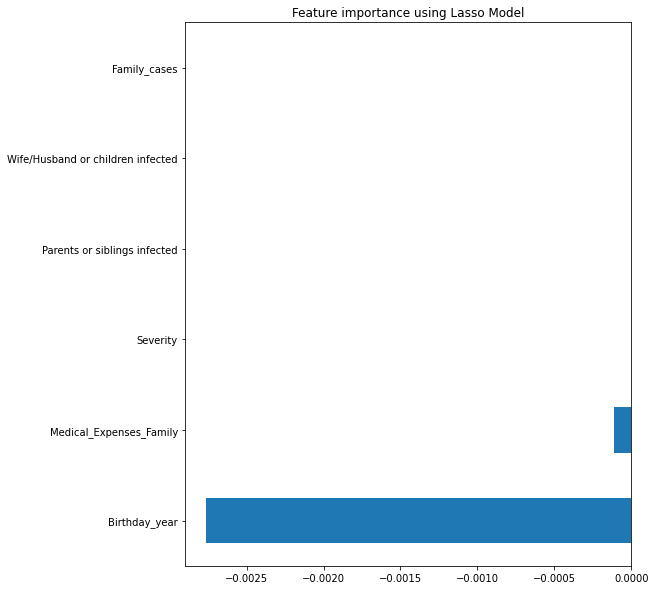

In [67]:
plot_importance(coef, 'Lasso')